# Data Access

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import matplotlib.image as mpimg
import os
from os import listdir
from sklearn.datasets import load_files

from os.path import isfile, join
from random import sample
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical   
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
def load_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

In [3]:
#read data

data = 'C:/Users/Zhenkun/Desktop/GU/590/final_project/data_part'
x, y, labels = load_data(data)


In [4]:
#split data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


In [5]:
# change type

def image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [6]:
X_train = np.array(image_to_array(X_train))
X_valid = np.array(image_to_array(X_valid))
X_test = np.array(image_to_array(X_test))

In [7]:
X_train=np.asarray(X_train).astype('float32')/255
y_train=np.asarray(y_train).reshape(-1,1)
y_train_cat = to_categorical(y_train, num_classes=10)
print((X_train.shape,y_train_cat.shape))

((1039, 224, 224, 3), (1039, 10))


In [8]:
X_test = np.asarray(X_test).astype('float32')/255
y_test = np.asarray(y_test).reshape(-1,1)
y_test_cat = to_categorical(y_test, num_classes=10)
print((X_test.shape,y_test_cat.shape))

((325, 224, 224, 3), (325, 10))


In [9]:
X_valid = np.asarray(X_valid).astype('float32')/255
y_valid = np.asarray(y_valid).reshape(-1,1)
y_valid_cat = to_categorical(y_valid, num_classes=10)
print((X_valid.shape,y_valid_cat.shape))

((260, 224, 224, 3), (260, 10))


# VGG19


In [10]:
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import TensorBoard
import tensorflow
import tensorflow.keras as tfk
from keras.callbacks import ModelCheckpoint, EarlyStopping
tfkl = tfk.layers


In [11]:
# add data augmentation

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
valid_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

train_generator.fit(X_train)
test_generator.fit(X_test)
valid_generator.fit(X_valid)

In [12]:
# use vgg19 model

base_model=VGG19(include_top=False, weights = 'imagenet', input_shape = (224,224,3), classes = y_test_cat.shape[1])

In [23]:
#add layers and compile model

VGG19 = tfk.Sequential()

VGG19.add(base_model)
for layer in VGG19.layers:
    layer.trainable = False
VGG19.add(tfkl.Dense(128,activation=('relu')))
VGG19.add(tfkl.GlobalMaxPooling2D())
VGG19.add(tfkl.Dense(10,activation=('softmax')))
VGG19.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
VGG19.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         65664     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
#add early stop and train model
Early_sp = EarlyStopping(monitor = 'val_accuracy', patience = 4,restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)

VGG19_results=VGG19.fit(X_train, y_train_cat,
                        batch_size=32,
                        epochs =20,
                        validation_data=(X_valid, y_valid_cat))
VGG19.save('VGG_model_part')                 

Train on 1039 samples, validate on 260 samples
Epoch 1/20
1039/1039 [==============================] - ETA: 16s - loss: 2.3495 - accuracy: 0.062 - ETA: 9s - loss: 2.3205 - accuracy: 0.109 - ETA: 7s - loss: 2.3110 - accuracy: 0.11 - ETA: 6s - loss: 2.3116 - accuracy: 0.11 - ETA: 5s - loss: 2.3074 - accuracy: 0.13 - ETA: 4s - loss: 2.2979 - accuracy: 0.17 - ETA: 4s - loss: 2.2879 - accuracy: 0.20 - ETA: 4s - loss: 2.2839 - accuracy: 0.21 - ETA: 3s - loss: 2.2765 - accuracy: 0.22 - ETA: 3s - loss: 2.2750 - accuracy: 0.22 - ETA: 3s - loss: 2.2694 - accuracy: 0.23 - ETA: 3s - loss: 2.2684 - accuracy: 0.23 - ETA: 2s - loss: 2.2595 - accuracy: 0.24 - ETA: 2s - loss: 2.2531 - accuracy: 0.25 - ETA: 2s - loss: 2.2521 - accuracy: 0.24 - ETA: 2s - loss: 2.2484 - accuracy: 0.24 - ETA: 2s - loss: 2.2495 - accuracy: 0.24 - ETA: 1s - loss: 2.2444 - accuracy: 0.25 - ETA: 1s - loss: 2.2399 - accuracy: 0.25 - ETA: 1s - loss: 2.2362 - accuracy: 0.25 - ETA: 1s - loss: 2.2346 - accuracy: 0.26 - ETA: 1s - lo

1039/1039 [==============================] - ETA: 3s - loss: 1.6344 - accuracy: 0.84 - ETA: 3s - loss: 1.5707 - accuracy: 0.90 - ETA: 3s - loss: 1.5967 - accuracy: 0.87 - ETA: 3s - loss: 1.5749 - accuracy: 0.89 - ETA: 3s - loss: 1.5716 - accuracy: 0.90 - ETA: 3s - loss: 1.5774 - accuracy: 0.90 - ETA: 2s - loss: 1.5698 - accuracy: 0.91 - ETA: 2s - loss: 1.5660 - accuracy: 0.91 - ETA: 2s - loss: 1.5683 - accuracy: 0.90 - ETA: 2s - loss: 1.5685 - accuracy: 0.90 - ETA: 2s - loss: 1.5680 - accuracy: 0.90 - ETA: 2s - loss: 1.5664 - accuracy: 0.91 - ETA: 2s - loss: 1.5696 - accuracy: 0.90 - ETA: 2s - loss: 1.5631 - accuracy: 0.91 - ETA: 1s - loss: 1.5628 - accuracy: 0.91 - ETA: 1s - loss: 1.5636 - accuracy: 0.91 - ETA: 1s - loss: 1.5623 - accuracy: 0.91 - ETA: 1s - loss: 1.5628 - accuracy: 0.91 - ETA: 1s - loss: 1.5663 - accuracy: 0.91 - ETA: 1s - loss: 1.5640 - accuracy: 0.91 - ETA: 1s - loss: 1.5651 - accuracy: 0.91 - ETA: 1s - loss: 1.5635 - accuracy: 0.91 - ETA: 1s - loss: 1.5679 - accura

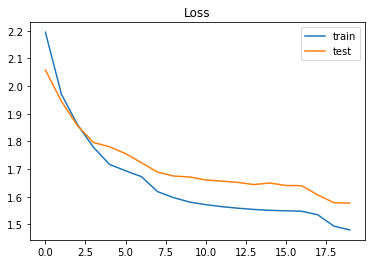

In [25]:
#check the loss

plt.title('Loss')
plt.plot(VGG19_results.history['loss'], label='train')
plt.plot(VGG19_results.history['val_loss'], label='test')
plt.legend()
plt.show()

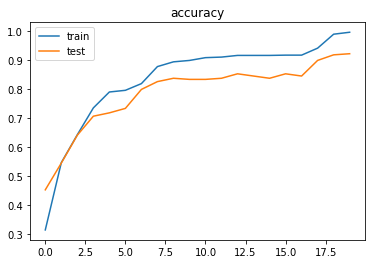

In [26]:
#check the accuracy

plt.title('accuracy')
plt.plot(VGG19_results.history['accuracy'], label='train')
plt.plot(VGG19_results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [27]:
# check the test accuracy
from sklearn.metrics import accuracy_score 

pred = VGG19.predict(X_test)
pred = pred.argmax(axis=1)
acc = accuracy_score(y_test, pred) 


In [28]:
print('Accuracy is',acc)

Accuracy is 0.916923076923077
